<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Seq_2_Seq/Seq2Seq_Basique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

# Création de la série d'entrée

In [ ]:
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/India_NRJ.csv"

--2021-05-31 14:56:15--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/India_NRJ.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745922 (728K) [text/plain]
Saving to: ‘India_NRJ.csv’

India_NRJ.csv       100%[===================>] 728.44K  --.-KB/s    in 0.04s   

2021-05-31 14:56:15 (19.7 MB/s) - ‘India_NRJ.csv’ saved [745922/745922]



In [ ]:
# Création de la série sous Pandas
df_data = pd.read_csv("India_NRJ.csv")
df_data

,Date,Purchase Bid (MW),Sell Bid (MW),MCV (MW),Cleared Volume (MW),Finale Scheduled Volume (MW),MCP (Rs/MWh)
0,2020-01-01 00:00:00,5225.8,20520.9,4828.60,4828.60,4828.60,2049.01
1,2020-01-01 00:15:00,5256.0,21183.2,4858.80,4858.80,4858.80,2029.46
2,2020-01-01 00:30:00,5183.3,22123.8,4786.20,4786.20,4786.20,2018.48
3,2020-01-01 00:45:00,5186.7,22804.6,4869.48,4869.48,4869.48,2000.04
4,2020-01-01 01:00:00,4915.1,24342.8,4610.60,4610.60,4610.60,1999.09
...,...,...,...,...,...,...,...
11611,2020-04-30 22:45:00,9743.7,10427.4,8644.60,8644.60,8644.60,3153.00
11612,2020-04-30 23:00:00,9606.0,10367.4,8492.50,8492.50,8492.50,2799.98
11613,2020-04-30 23:15:00,9397.0,10524.4,8483.50,8483.50,8483.50,2799.90
11614,2020-04-30 23:30:00,9153.0,10636.4,8314.70,8314.70,8314.70,2700.50


In [ ]:
X = df_data['Purchase Bid (MW)']
X = X.astype(dtype=np.float32)
X

0        5225.799805
1        5256.000000
2        5183.299805
3        5186.700195
4        4915.100098
            ...     
11611    9743.700195
11612    9606.000000
11613    9397.000000
11614    9153.000000
11615    8741.000000
Name: Purchase Bid (MW), Length: 11616, dtype: float32

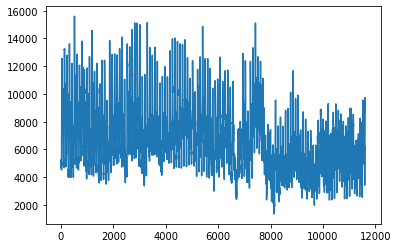

In [ ]:
plt.plot(X)

# Séparation des données de test et d'entrainement

In [ ]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(X) * pourcentage)
date_separation = X.index[temps_separation]

serie_entrainement_X = np.array(X.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(X.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 9292
Taille de la validation : 2324


**Normalisation des données :**

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
serie_entrainement_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_entrainement_X,shape=(len(serie_entrainement_X),1)))
serie_test_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_test_X,shape=(len(serie_test_X),1)))

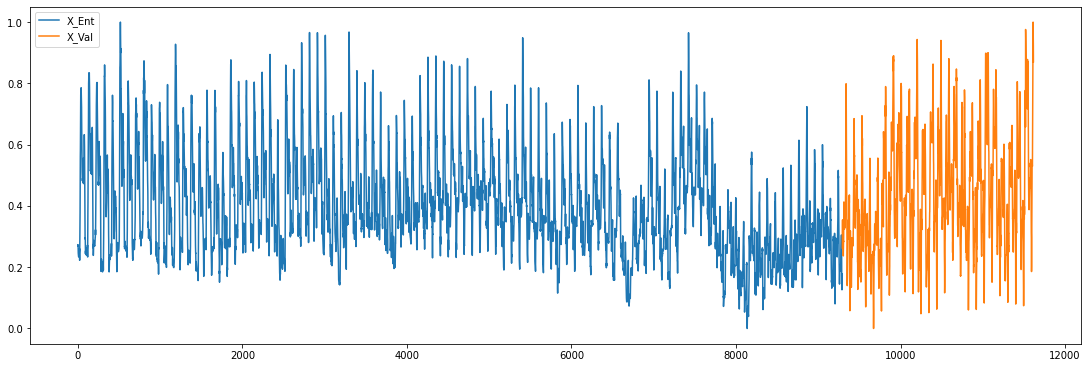

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(X.index[:temps_separation].values,serie_entrainement_X_norm, label="X_Ent")
ax.plot(X.index[temps_separation:].values,serie_test_X_norm, label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, longueur_sequence, longueur_sortie, batch_size,shift):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  dataset = dataset.map(lambda x: (x[0:longueur_sequence][:,:],tf.expand_dims(x[-longueur_sortie:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 512
longueur_sequence = 60
longueur_sortie = 24
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

17
(512, 60, 1)
(512, 24, 1)


In [ ]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0].shape)
  print(element[1].shape)

4
(512, 60, 1)
(512, 24, 1)


In [ ]:
for element in dataset.take(1):
  print(element)

(<tf.Tensor: shape=(512, 60, 1), dtype=float64, numpy=
array([[[0.27157051],
        [0.27369123],
        [0.26858606],
        ...,
        [0.4902005 ],
        [0.48896455],
        [0.4853481 ]],

       [[0.27369123],
        [0.26858606],
        [0.26882484],
        ...,
        [0.48896455],
        [0.4853481 ],
        [0.4755451 ]],

       [[0.26858606],
        [0.26882484],
        [0.24975247],
        ...,
        [0.4853481 ],
        [0.4755451 ],
        [0.47523613]],

       ...,

       [[0.72392121],
        [0.82015381],
        [0.85400794],
        ...,
        [0.26718865],
        [0.26796109],
        [0.26045434]],

       [[0.82015381],
        [0.85400794],
        [0.85495594],
        ...,
        [0.26796109],
        [0.26045434],
        [0.26060884]],

       [[0.85400794],
        [0.85495594],
        [0.87617005],
        ...,
        [0.26045434],
        [0.26060884],
        [0.26706929]]])>, <tf.Tensor: shape=(512, 24, 1), dtype=float64, n

On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,5,779),(32,5,1)) => x = 60x(32,5,779) ; y = 60x(32,5,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,5,779) => (60,32,5,779)
y = np.asarray(y,dtype=np.float32)      # 60x(32,5,1) => (60,32,5,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))     # (60,32,5,779) => (60*32,5,779)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))     # (60,32,5,1) => (60*32,5,1)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(8704, 60, 1)
(8704, 24, 1)


Puis la même chose pour les données de validation :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))

# Recombine les données
x = np.asarray(x,dtype=np.float32)
y = np.asarray(y,dtype=np.float32)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(2048, 60, 1)
(2048, 24, 1)


# Affichage des séries

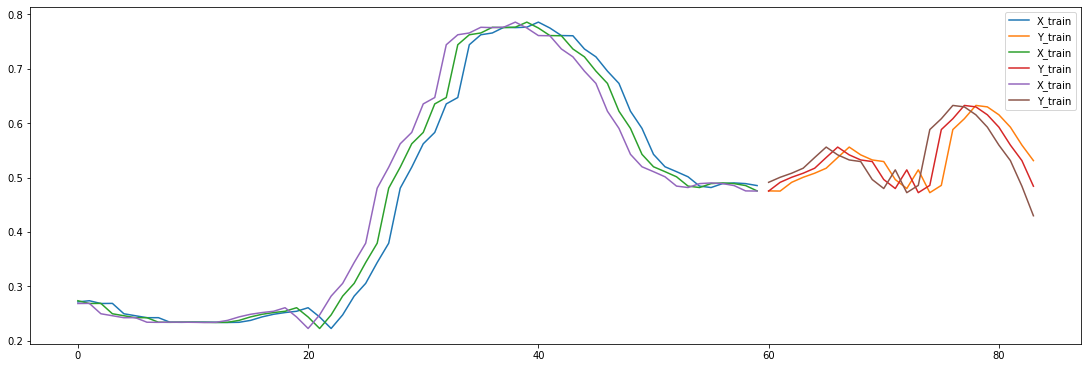

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,3):
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[i],label="X_train")
  ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[i],label="Y_train")

ax.legend()
plt.show()

# Création du modèle Seq2Seq basique

<img src="https://github.com/AlexandreBourrieau/essais_ML/blob/main/Seq2Seq_Time_Series.png?raw=true" width="600"> 

**1. Création de la couche d'encodeur**

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Encodeur")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,1,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self, input, hidden=None):
    out_enc, out_hid = self.couche_GRU(input,initial_state=hidden)
    return out_enc, out_hid


**2. Création de la couche de décodeur**

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Decodeur")
    self.couche_Dense1 = tf.keras.layers.Dense(units=16,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU,activation="relu")
    self.couche_Dense2 = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=16)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden=None):
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(input)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(input,initial_state=hidden)
    out_dec = self.couche_Dense1(out_dec)
    out_dec = self.couche_Dense2(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée réseau         : (batch_size,longueur_sequence,1) 
  # Sorties :
  def call(self,input):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input[:,0:1,:])

    for i in range(1,longueur_entree):
      enc_out, enc_hid = self.encodeur(input[:,i:i+1,:],enc_hid)

    dec_input = tf.expand_dims(input[:,-1,:],1)
    dec_hid = enc_hid

    for i in range(0,self.longueur_sortie):
      dec_out, dec_hid = self.decodeur(dec_input, dec_hid)
      dec_input = tf.expand_dims(dec_out,-1)
      sortie.append(dec_out)
    sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    return sortie

**4. Création du modèle**

In [ ]:
dim_GRU = 128
drop=0.1

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))

encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop)
decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop)

sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences)

model = tf.keras.Model(entrees_sequences,sortie)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
net_gru_1 (Net_GRU)          (None, 24, 1)             102689    
Total params: 102,689
Trainable params: 102,689
Non-trainable params: 0
_________________________________________________________________


# Création du modèle Seq2Seq basique avec Attention simple

**1. Création de la couche d'encodeur**

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=True,return_state=True,name="GRU_Encodeur")
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,longueur_sequence,1) 
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,longueur_sequence,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,128)
  def call(self, input):
    drop_out = self.drop(input)
    out_enc, out_hid = self.couche_GRU(drop_out)
    return out_enc, out_hid


**2. Création de la couche de décodeur et d'attention**

In [ ]:
# Classe d'attention simple
# Applique les poids d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self):
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.w = self.add_weight(shape=(input_shape[2],1),initializer="normal",name="w")
    self.b = self.add_weight(shape=(input_shape[1],1),initializer="zeros",name="b")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, longueur_sequence,128)
  def call(self,x):
    e = tf.matmul(x,self.w) + self.b                # (32,20,40)x(40,1) + (20,1) = (32,20,1)
    e = K.tanh(e)                                   # (32,20,1)
    a = tf.keras.activations.softmax(e,axis=1)      # (32,20,1)
    xa = tf.multiply(x,a)                           # (32,20,40)
    sortie = K.sum(xa,axis=1)                       # (32,40)
    return sortie

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,name="GRU_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    self.CoucheAttention = Couche_Attention()
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  #     enc_out : Sortie encodeur       : (batch_size, longueur_sequence, dim_GRU )
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input, hidden=None, enc_out):
    vecteur_contexte = self.CoucheAttention(hidden, enc_out)
    
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(drop)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(drop,initial_state=hidden)
    drop = self.drop(out_dec)
    out_dec =  self.couche_Dense(drop)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée réseau         : (batch_size,longueur_sequence,1) 
  # Sorties :
  def call(self,input):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input)               # input : (batch_size,longueur_sequence,1)
                                                          # enc_out : (batch_size,longueur_sequence,dim_GRU)
                                                          # enc_hid : (batch_size,dim_GRU)

    dec_input = tf.expand_dims(input[:,-1,:],1)           # dec_input : (batch_size, 1,1)

    for i in range(0,self.longueur_sortie):
      dec_out, dec_hid = self.decodeur(dec_input, dec_hid, enc_out)     # dec_out : (batch_size,1)
                                                                        # dec_hid : (batch_size,dim_GRU)
      dec_input = tf.expand_dims(dec_out,-1)                            # dec_input : (batch_size,1,1)
      sortie.append(dec_out)
    sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    return sortie

**4. Création du modèle**

In [ ]:
dim_GRU = 128
drop=0.0

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))

encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop)
decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop)

sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences)

model = tf.keras.Model(entrees_sequences,sortie)
model.summary()

# Création du modèle Seq2Seq basique avec Attention Vecteur Contexte

**1. Création de la couche d'encodeur**

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=True,return_state=True,name="GRU_Encodeur")
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,longueur_sequence,1) 
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,longueur_sequence,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,128)
  def call(self, input):
    drop_out = self.drop(input)
    out_enc, out_hid = self.couche_GRU(drop_out)
    return out_enc, out_hid


**2. Création de la couche de décodeur et d'attention**

In [ ]:
# Classe d'attention simple
# Applique les poids d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention_VC(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer="normal",name="W")
    self.b = self.add_weight(shape=(self.dim_att,1),initializer="zeros",name="b")
    self.u = self.add_weight(shape=(self.dim_att,1),initializer="normal",name="u")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])         # (None,20,40) => (None, 40,20)
    Xh = tf.matmul(self.W,xt)                 # (#Att,40)x(None,40,20) = (None,#Att,20)
    Xh = K.tanh(Xh + self.b)                  # Xh = (None,#Att,20)

    # Calcul des poids d'attention normalisés
    Xh = tf.transpose(Xh,perm=[0,2,1])        # Xh = (None,#Att,20) => (None,20,#Att)
    a = tf.matmul(Xh,self.u)                  # (None,20,#Att)x(#Att,1) = (None,20,1)
    a = tf.keras.activations.softmax(a,axis=1)

    # Calcul du vecteur d'attention
    xa = tf.multiply(x,a)                     # (None,20,40)_x_(None,20,1) = (None,20,40)
    sortie = K.sum(xa,axis=1)                 # sortie = (None,40)
    return sortie

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,name="GRU_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden=None):
    drop = self.drop(input)
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(drop)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(drop,initial_state=hidden)
    drop = self.drop(out_dec)
    out_dec =  self.couche_Dense(drop)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, dim_att = 64, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    self.dim_att = dim_att
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheAttention = Couche_Attention_VC(dim_att=self.dim_att)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée réseau         : (batch_size,longueur_sequence,1) 
  # Sorties :
  def call(self,input):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input)               # input : (batch_size,longueur_sequence,1)
                                                          # enc_out : (batch_size,longueur_sequence,dim_GRU)
                                                          # enc_hid : (batch_size,dim_GRU)

    dec_input = tf.expand_dims(input[:,-1,:],1)           # dec_input : (batch_size, 1,1)
    dec_hid = self.CoucheAttention(enc_out)               # dec_hid : (batch_size,dim_GRU)

    for i in range(0,self.longueur_sortie):
      dec_out, dec_hid = self.decodeur(dec_input, dec_hid)              # dec_out : (batch_size,1)
                                                                        # dec_hid : (batch_size,dim_GRU)
      dec_input = tf.expand_dims(dec_out,-1)                            # dec_input : (batch_size,1,1)
      sortie.append(dec_out)
    sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    return sortie

**4. Création du modèle**

In [ ]:
dim_GRU = 128
dim_att = 128
drop=0.0

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))

encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop)
decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop)

sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie,dim_att=dim_att)(entrees_sequences)

model = tf.keras.Model(entrees_sequences,sortie)
model.summary()

# Création du modèle Seq2Seq basique avec Auto-Attention

**1. Création de la couche d'encodeur**

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=True,return_state=True,name="GRU_Encodeur")
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,longueur_sequence,1) 
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,longueur_sequence,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,128)
  def call(self, input):
    drop_out = self.drop(input)
    out_enc, out_hid = self.couche_GRU(drop_out)
    return out_enc, out_hid


**2. Création de la couche de décodeur et d'attention**

In [ ]:
# Classe d'auto-attention
# Applique les poids de la matrice d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Auto_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att,nbr_hop):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    self.nbr_hop = nbr_hop
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer='glorot_uniform',name="W")
    self.U = self.add_weight(shape=(self.nbr_hop,self.dim_att),initializer='glorot_uniform',name="U")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])           # (None,20,40) => (None,40,20)
    Xh = tf.matmul(self.W,xt)                   # (#Att,40)x(None,40,20) = (None,#Att,20)
    Xh = K.tanh(Xh)                             # Xh = (None,#Att,20)

    # Calcul de la matrice des poids d'attention normalisés
    A = tf.matmul(self.U,Xh)                    # (#hop,#Att)x(None,#Att,20) = (None,#Att,20)
    A = tf.keras.activations.softmax(A,axis=2)  # (None,#Att,20)

    # Calcul de la matrice des vecteur d'attentions
    sortie = tf.matmul(A,x)                     # (None,#Att,20)x(None,20,40) = (None,#Att,40)
    return tf.keras.layers.Flatten()(sortie)    # sortie : (None, #att*40)

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,name="GRU_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    self.drop = tf.keras.layers.Dropout(self.drop)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden=None):
    drop = self.drop(input)
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(drop)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(drop,initial_state=hidden)
    drop = self.drop(out_dec)
    out_dec =  self.couche_Dense(drop)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, dim_att = 64, nbr_hop = 5, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    self.dim_att = dim_att
    self.nbr_hop = nbr_hop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.CoucheAttention = Couche_Auto_Attention(dim_att=self.dim_att, nbr_hop = self.nbr_hop)
    self.Dense = tf.keras.layers.Dense(self.dim_GRU,activation="tanh")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée réseau         : (batch_size,longueur_sequence,1) 
  # Sorties :
  def call(self,input):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input)               # input : (batch_size,longueur_sequence,1)
                                                          # enc_out : (batch_size,longueur_sequence,dim_GRU)
                                                          # enc_hid : (batch_size,dim_GRU)

    dec_input = tf.expand_dims(input[:,-1,:],1)           # dec_input : (batch_size, 1,1)
    dec_hid = self.CoucheAttention(enc_out)               # dec_hid : (batch_size,dim_Att*dim_GRU)
    dec_hid = self.Dense(dec_hid)                         # dec_hid : (batch_size,dim_GRU)

    for i in range(0,self.longueur_sortie):
      dec_out, dec_hid = self.decodeur(dec_input, dec_hid)              # dec_out : (batch_size,1)
                                                                        # dec_hid : (batch_size,dim_GRU)
      dec_input = tf.expand_dims(dec_out,-1)                            # dec_input : (batch_size,1,1)
      sortie.append(dec_out)
    sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    return sortie

**4. Création du modèle**

In [ ]:
dim_GRU = 128
drop=0.0

entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))

encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop)
decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop)

sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie,dim_att=dim_GRU)(entrees_sequences)

model = tf.keras.Model(entrees_sequences,sortie)
model.summary()

# Entrainement du modèle

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
#optimiseur=tf.keras.optimizers.Adam()
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse"])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='mse', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
#historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])
historique = model.fit(x=x_train,y=y_train, epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint], batch_size=1024)



Epoch 1/100
9/9 [==============================] - 97s 100ms/step - loss: 0.1892 - mse: 0.1892

Epoch 00001: mse improved from inf to 0.18917, saving model to poids.hdf5
Epoch 2/100
9/9 [==============================] - 1s 103ms/step - loss: 0.1891 - mse: 0.1891

Epoch 00002: mse improved from 0.18917 to 0.18912, saving model to poids.hdf5
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1891 - mse: 0.1891

Epoch 00003: mse did not improve from 0.18912
Epoch 4/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1891 - mse: 0.1891

Epoch 00004: mse improved from 0.18912 to 0.18910, saving model to poids.hdf5
Epoch 5/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1891 - mse: 0.1891

Epoch 00005: mse did not improve from 0.18910
Epoch 6/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1891 - mse: 0.1891

Epoch 00006: mse did not improve from 0.18910
Epoch 7/100
9/9 [==============================] - 1s 98ms/step -

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

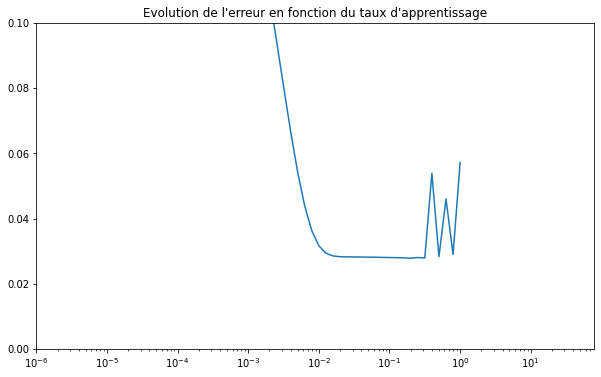

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[20], taux[99], 0, 0.1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from google.colab import files

max_periodes = 500

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True


# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.04,
    decay_steps=10,
    decay_rate=0.0001)

#optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-4,periodes = 10, term="loss")],batch_size=2048)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-7,periodes = 10, term="loss")])

#files.download('poids_train.hdf5')

Epoch 1/500
17/17 [==============================] - 110s 2s/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0554 - val_mse: 0.0554

Epoch 00001: loss improved from inf to 0.02618, saving model to poids_train.hdf5
Epoch 2/500
17/17 [==============================] - 2s 128ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0467 - val_mse: 0.0467

Epoch 00002: loss did not improve from 0.02618
Epoch 3/500
17/17 [==============================] - 2s 127ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0588 - val_mse: 0.0588

Epoch 00003: loss did not improve from 0.02618
Epoch 4/500
17/17 [==============================] - 2s 128ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0670 - val_mse: 0.0670

Epoch 00004: loss did not improve from 0.02618
Epoch 5/500
17/17 [==============================] - 2s 129ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0586 - val_mse: 0.0586

Epoch 00005: loss did not improve from 0.02618
Epoch 6/500
17/17 [==============================] - 2s 130ms/

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
model.evaluate(dataset)
model.evaluate(dataset_val)

4/4 [==============================] - 0s 77ms/step - loss: 0.0271 - mse: 0.0271


[0.027120068669319153, 0.027120068669319153]

# Prédictions

In [ ]:
pred_ent = model.predict(dataset)
pred_val = model.predict(dataset_val)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=X.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=X.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

pred = []
max = len(pred_ent)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:shift,:],1))
toto = tf.convert_to_tensor(pred)
toto = tf.reshape(toto,shape=(toto.shape[0]*toto.shape[1]))
fig.add_trace(go.Scatter(x=X.index[longueur_sequence:longueur_sequence+max],y=toto, mode='lines', line=dict(color='green', width=1)))

pred = []
max = len(pred_val)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:shift,:],1))
toto = tf.convert_to_tensor(pred)
toto = tf.reshape(toto,shape=(toto.shape[0]*toto.shape[1]))
fig.add_trace(go.Scatter(x=X.index[temps_separation+longueur_sequence:temps_separation+longueur_sequence+max],y=toto, mode='lines', line=dict(color='green', width=1)))



fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [ ]:
tf.squeeze(tf.convert_to_tensor(pred),1)

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.32390574, 0.28396055, 0.25559783, ..., 0.450209  , 0.42260098,
       0.39268285], dtype=float32)>

In [ ]:
for i in range(0,3):
  pred = tf.squeeze(pred_ent[i+shift-1,0:1,:],1)

  fig.add_trace(go.Scatter(x=X_norm.index[(i+1)*longueur_sequence:(2+i)*(longueur_sequence+longueur_sortie)],y=pred,line=dict(color='green', width=1)))

#  fig.add_trace(go.Scatter(x=X_norm.index[i*longueur_sequence:(1+i)*(longueur_sequence+longueur_sortie)],y=train,line=dict(color='green', width=1)))

NameError: ignored

In [ ]:
pred_ent